# Error en Integración Númerica

In [6]:
%load_ext autoreload
%autoreload 1
%aimport numa_teaching.formatting
from numa_teaching.formatting import fltx, nan_sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# sympy
from sympy import init_printing
from sympy import I, nroots, lambdify, diff, latex, symbols, pi, interpolating_poly, cos, N, integrate, Integral, exp, solve
from sympy.abc import x, epsilon, alpha
import operator
import functools
init_printing()
#init_printing(use_latex=False)

In [8]:
# numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9] # ancho, alto de figuras
plt.rcParams["font.size"] = 20

In [9]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex

In [10]:
from collections import namedtuple
from itertools import zip_longest
from functools import partial

Latex macros
$$ 
\newcommand{\d}{\mathrm{d}}
\DeclareMathOperator{\deg}{deg}
$$

## Error del metodo trapezoidial

**Teorema**
Suponemos que $f(x)$ tiene dos derivadas continuas en el intervalo $[a, b]$. Con eso tenemos
$$
E^T_n(f) \equiv \int_a^b f(x)\,\d x - T_n(f) = - \frac{h^2(b-a)}{12} f''(c_n)
$$
para algún $c_n \in [a, b]$.

Esta formula nos dice que el error es aproximadamente proporcional a $h^2$. Entonces duplicar $n$ y dividir $h$ por 2 debería reducir el error por un factor 4. Eso es lo que hemos observado en nuestros ejemplos.

### Ejemplo

Queremos evaluar
$$
\int_0^2 \frac{\d x}{1 + x^2}
$$
usando el metodo del trapezoide $T_n(f)$. Como tenemos que elegir $n$ para asegurarnos
$$
\left|E^T_n(f)\right| \leq 5 \times 10^{-6}
$$
Las derivadas son
$$
f'(x) = \frac{-2}{\bigl(1 + x^2\bigr)^2}, \qquad f''(x) = \frac{-2 + 6 x^2}{\bigl(1 + x^2\bigr)^3}
$$

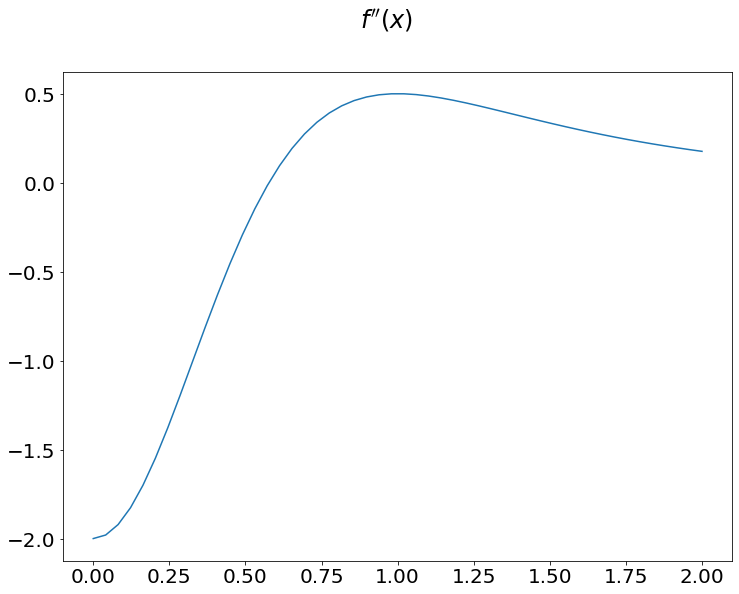

In [11]:
def f1pp(x):
    return (-2 + 6 * x**2) / (1 + x**2)**3

x1r = np.linspace(0, 2)
plt.plot(x1r, f1pp(x1r))
plt.suptitle(r"$f''(x)$");

Vemos que 
$$
\max_{0 \leq x \leq 2} \bigl| f''(x) \bigr| = 2
$$

Usamos $b - a = 2$ para obtener
\begin{align}
E^T_n(f) &= -\frac{h^2 (b - a)}{12} f''(c_n)\\
  &\leq \frac{h^2 2}{12} 2 = \frac{h^2}{3}\\
\end{align}
Como no conocemos a $c_n$ usamos el máximo de $|f''(x)|$ para tener una cota garantizada para el error.

Buscamos $h$ para obtener
$$
\bigl| E^T_n(f) \bigr| \leq 5 \times 10^{-6}
$$
Lo podemos garantizar con
$$
\frac{h^2}{3} \leq 5 \times 10^{-6}
$$
Para $h$ y $n$ nos da
\begin{align}
h &\leq 0.003873\\
n = \frac{2}{h} &\geq 516.4
\end{align}
que nos dice que tenemos que eligir $n \geq 517$.

## Derivación de la formula para el error

La derivación de la formula se hace en 2 pasos:

1. Obtener una expresión para el error en el caso de un solo sub-intervalo ($n = 1$).
2. Generalizar el resultado para $n$ aribratio para recuperar la expresión general.

Para el metodo del trapezoide con un solo intervalo tenemos
$$
\int_\alpha^{\alpha + h} f(x)\,\d x - \frac{h}{2}[f(\alpha) + f(\alpha + h)] = -\frac{h^3}{12} f''(c)
$$
para algún $c \in [\alpha, \alpha + h]$. Esta formula se obtiene a partir de la expresión del error de la interpolación lineal.

Nos recordamos de la expresión para la regla del trapezoide
$$
h = \frac{b - a}{n}, \qquad x_j = a + j\,h,\quad j=0, 1, \dots, n
$$
\begin{align}
I &= \int_{x_0}^{x_n} f(x)\,\d x\\
  &= \int_{x_0}^{x_1} f(x)\,\d x + \int_{x_1}^{x_2} f(x)\,\d x + \dots + \int_{x_{n-1}}^{x_n} f(x)\,\d x\\
  &\approx \frac{h}{2}[f(x_0) + f(x_1)] + \frac{h}{2}[f(x_1) + f(x_2)] \\
  & \quad + \dots \\
  & \quad + \frac{h}{2}[f(x_{n-2}) + f(x_{n-1})] + \frac{h}{2}[f(x_{n-1}) + f(x_n)] \\
\end{align}


En este caso el error
$$
E^T_n(f) \equiv \int_a^b f(x)\,\d x - T_n(f)
$$
puede analizarse sumando los errores de los sub-intervalos $[x_0, x_1]$, $[x_1, x_2]$, $\dots$, $[x_{n-1}, x_n]$. Nos recordamos que
$$
\int_\alpha^{\alpha + h} f(x)\,\d x - \frac{h}{2}[f(\alpha) + f(\alpha + h)] = -\frac{h^3}{12} f''(c)
$$
Entonces en $[x_{j-1}, x_j]$:
$$
\int_{x_{j-1}}^{x_j} f(x)\,\d x - \frac{h}{2}[f(x_{j-1}) + f(x_j)] = -\frac{h^3}{12} f''(\gamma_j)
$$
para algún $\gamma_j$ con $x_{j-1} \leq \gamma_j \leq x_j$. Sumando los errores obtenemos
$$
E^T_n(f) = -\frac{h^3}{12}f''(\gamma_1) - \dots -\frac{h^3}{12}f''(\gamma_n)
$$
Vermos como simplificar esta expresión.

Otra manera de escibir el error es
$$
E^T_n(f) = - \frac{h^3 n}{12} \underbrace{\left[ \frac{f''(\gamma_1) + \dots + f''(\gamma_n)}{n} \right]}_{\zeta_n}
$$
Los parentesis tienen que satisfacer
$$
\min_{a \leq x \leq b} f''(x) \leq \zeta_n \leq \max_{a \leq x \leq b} f''(x)
$$
Por suposición, $f''(x)$ es continua. Entonces existe $c_n \in [a, b]$ con
$$
f''(c_n) = \zeta_n
$$
Con eso y con $hn = b - a$ obtenemos
\begin{align}
E^T_n(f) &=  - \frac{h^3 n}{12} \left[ \frac{f''(\gamma_1) + \dots + f''(\gamma_n)}{n} \right]\\
  &= -\frac{h^2(b - a)}{12} f''(c_n)
\end{align}
que es la expresión dada al inicio.

## Estimado del error

Para obtener una forma para estimar el error regresamos a
$$
E^T_n(f) = -\frac{h^3}{12}f''(\gamma_1) - \dots -\frac{h^3}{12}f''(\gamma_n)
$$
y lo re-escribimos como
$$
E^T_n(f) = -\frac{h^3}{12}\bigl[f''(\gamma_1) + \dots + f''(\gamma_n) \bigr]
$$
La cantidad 
$$
f''(\gamma_1)h + \dots + f''(\gamma_n)h
$$
es la *Suma de Riemann* para la integral
$$
\int_a^b f''(x)\,\d x = f'(b) - f'(a)
$$
por la relación
$$
\lim_{n \to \infty} \bigl[ f''(\gamma_1) h + \dots + f''(\gamma_n) h \bigr] = \int_a^b f''(x)\,\d x
$$

Entonces tenemos
$$
f''(\gamma_1)h + \dots + f''(\gamma_n)h \approx f'(b) - f'(a)
$$
para $n$ grande. En combinación con la expresión
$$
E^T_n(f) = -\frac{h^3}{12}\bigl[f''(\gamma_1) + \dots + f''(\gamma_n) \bigr]
$$
para el error obtenemos
$$
E^T_n(f) \approx \frac{h^2}{12} \bigl[ f'(b) - f'(a) \bigr] \equiv \tilde E^T_n(f)
$$
Es un estimado del error que se puede evaluar, llamado *estimado asimptotico del error*.

### Ejemplo 

$$
I(f) = \int_0^\pi e^x \cos x \,\d x = - \frac{e^\pi + 1}{2} \doteq - 12.070346
$$
En este caso
\begin{align}
f'(x)  &= e^x [\cos x - \sin x]\\
f''(x) &= -2 e^x \sin x\\
\max_{0 \leq x \leq \pi} |f''(x)| &= |f''(0.75\pi)| = 14.921
\end{align}

Nos da
\begin{align}
E^T_n(f) &= -\frac{h^2 (b - a)}{12} f''(c_n)\\
|E^T_n(f)| &\leq \frac{h^2 \pi}{12} \cdot 14.921 = 3.906 h^2
\end{align}
y
\begin{align}
\tilde E^T_n(f) &= -\frac{h^2}{12} [f'(\pi) - f'(0)]\\
  &= \frac{h^2}{12} [e^\pi +1] \doteq 2.012 h^2
\end{align}

In [12]:
def trapezoidal(f, fp, rang, exact, log_n=8):
    T1 = (rang[1] - rang[0]) / 2 * (f(rang[0]) + f(rang[1]))
    err1 = exact - T1
    h = rang[1] - rang[0]
    n = 1
    err_est = - h**2/12 * (fp(rang[1]) - fp(rang[0]))
    res = [[1, T1, err_est, err1, np.nan]]
    for i in range(log_n):
        h /= 2
        Tn = T1 / 2
        for j in range(n):
            Tn += h * f(rang[0] + h + 2*j*h)
        n *= 2
        err_n = exact - Tn 
        err_est = - h**2/12 * (fp(rang[1]) - fp(rang[0]))
        res.append([n, Tn, err_est, err_n, err1 / err_n])
        err1 = err_n
        T1 = Tn
    return res

def f1(x):
    return np.exp(x) * np.cos(x)

def f1p(x):
    return np.exp(x) * (np.cos(x) - np.sin(x))

tab1 = trapezoidal(f1, f1p, (0, np.pi), -(np.exp(np.pi) +1) / 2)

En la tabla notamos que el error y el error estimado están muy cerca.

In [13]:
tab1 = pd.DataFrame(tab1, columns=["$n$", "$T_n(f)$", "Error (est)", "Error", "Ratio"]) 
tab1.style.format(dict(zip(tab1.columns, ["{:g}", "{:.9f}", "{:.2e}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$T_n(f)$,Error (est),Error,Ratio
0,1,-34.778518660,1.99e+01,2.27e+01,
1,2,-17.389259330,4.96e+00,5.32e+00,$4.27$
2,4,-13.336022847,1.24e+00,1.27e+00,$4.20$
3,8,-12.382162430,3.10e-01,3.12e-01,$4.06$
4,16,-12.148004100,7.76e-02,7.77e-02,$4.02$
5,32,-12.089742117,1.94e-02,1.94e-02,$4.00$
6,64,-12.075194099,4.85e-03,4.85e-03,$4.00$
7,128,-12.071558189,1.21e-03,1.21e-03,$4.00$
8,256,-12.070649280,3.03e-04,3.03e-04,$4.00$


Usamos entonces
\begin{align}
I(f) - T_n(f) &\approx \frac{h^2}{12} [e^\pi + 1]\\
I(f) &\approx T_n(f) + \frac{h^2}{12} [e^\pi + 1]\\
\end{align}
que es la *regla del trapeziode corregida*.

In [14]:
def trapezoidal_corr(f, fp, rang, exact, log_n=8):
    h = rang[1] - rang[0]
    n = 1
    err_est = - h**2/12 * (fp(rang[1]) - fp(rang[0]))
    T1 = (rang[1] - rang[0]) / 2 * (f(rang[0]) + f(rang[1]))
    T1_corr = T1 + err_est
    err1 = exact - T1_corr
    res = [[1, T1_corr, err1, np.nan]]
    for i in range(log_n):
        h /= 2
        Tn = T1 / 2
        for j in range(n):
            Tn += h * f(rang[0] + h + 2*j*h)
        n *= 2
        err_est = - h**2/12 * (fp(rang[1]) - fp(rang[0]))
        Tn_corr = Tn + err_est
        err_n = exact - Tn_corr
        res.append([n, Tn_corr, err_n, err1 / err_n])
        err1 = err_n
        T1 = Tn
    return res

tab1c = trapezoidal_corr(f1, f1p, (0, np.pi), -(np.exp(np.pi) +1) / 2)

In [15]:
tab1c = pd.DataFrame(tab1c, columns=["$n$", "$T_n(f)$", "Error", "Ratio"]) 
tab1c.style.format(dict(zip(tab1c.columns, ["{:g}", "{:.9f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$T_n(f)$,Error,Ratio
0,1,-14.923594806,2.85e+00,
1,2,-12.425528367,3.55e-01,$8.03$
2,4,-12.095090106,2.47e-02,$14.35$
3,8,-12.071929245,1.58e-03,$15.63$
4,16,-12.070445804,9.95e-05,$15.91$
5,32,-12.070352543,6.23e-06,$15.98$
6,64,-12.070346706,3.89e-07,$15.99$
7,128,-12.070346341,2.43e-08,$16.00$
8,256,-12.070346318,1.52e-09,$16.00$


En general 
\begin{align}
I(f) - T_n(f) &\approx \frac{h^2}{12} [f'(b) - f'(a)]\\
I(f) &\approx T_n(f) + \frac{h^2}{12} [f'(b) - f'(a)]\\
\end{align}
que es la *regla del trapeziode corregida*.

## Error de la regla de Simpson

La regla de Simpson es
\begin{align}
\int_a^b f(x)\,\d x \approx S_n(f) \equiv & \frac{h}{3} \bigl[ f(x_0) + 4 f(x_1) \\
  & + 2f(x_2) + 4 f(x_3) + 2f(x_4)\\
  & + \dots + 2f(x_{n-2}) + 4f(x_{n-1}) + f(x_n) \bigr] 
\end{align}
Su error es
$$
E^S_n(f) \equiv \int_a^b f(x)\,\d x - S_n(f) = -\frac{h^4 (b-a)}{180} f^{(4)}(c_n)
$$
para algún $c_n \in [a, b]$. El estimado asintotico del error es
$$
\int_a^b f(x)\,\d x - S_n(f) \approx \tilde E^S_n(f) \equiv -\frac{h^4}{180}\bigl[ f'''(b) - f'''(a) \bigr]
$$

### Discusión

Ambas expresiónes para el error de la regla de Simpson suponen que $f(x)$ tiene 4 derivadas continuas en el intervalo $[a, b]$. Luego vermos que pasa cuando no es cumpla.

Ambas expresiones nos dicen que el error baja por un factor 4 cuando duplicamos $n$.

Comparamos con el caso de la regla del trapezoide
$$
E^T_n(f) \equiv \int_a^b f(x)\,\d x - T_n(f) = - \frac{h^2(b-a)}{12} f''(c_n)
$$
$$
E^T_n(f) \approx \frac{h^2}{12} \bigl[ f'(b) - f'(a) \bigr] \equiv \tilde E^T_n(f)
$$
1. Necesita solamente 2 derivadas continuas
2. El error baja solamente por un factor 4 cuando duplicamos $n$.

### Ejemplo

Queremos evaluar
$$
\int_0^2 \frac{\d x}{1 + x^2}
$$
usando el metodo del trapezoide $T_n(f)$. Como tenemos que elegir $n$ para asegurarnos
$$
\left|E^T_n(f)\right| \leq 5 \times 10^{-6}
$$
Usamos
\begin{align}
f^{(4)}(x) &= 24\frac{5x^4 - 10 x^2 + 1}{\bigl( 1 + x^2 \bigr)^5}\\
\max_{0 \leq x \leq 2} |f^{(4)}(x)| &= f^{(4)}(0) = 24
\end{align}
para obtener
\begin{align}
E^S_n(f) &= -\frac{h^4 (b - a)}{180} f^{(4)}(c_n)\\
|E^S_n(f)| &\leq \frac{h^2 \cdot 2}{180} \cdot 24 = \frac{4h^4}{15}
\end{align}


EL requisito $|E^S_n(f)| \leq 5 \times 10^{-6}$ se cumple para
\begin{align}
\frac{4h^4}{15} &\leq 5 \times 10^{-6}\\
h &\leq 0.0658\\
n &\geq 30.39
\end{align}
Entonces eligir $n \geq 31$ nos permite garantizar el error. Lo comparamos con el caso de la regla del trapezoide, donde se necesitaban $n \geq 517$ sub-intervalos.

Para el error asintotico estimamos
\begin{align}
f'''(x) & = -24x \frac{x^2 - 1}{\bigl( 1 + x^2 \bigr)^5}\\
\tilde E^S_n(f) &\equiv -\frac{h^4}{180} [f'''(2) - f'''(0)]\\
  &= \frac{h^4}{180} \cdot \frac{144}{625} = \frac{4}{3125} h^4
\end{align}


## Integración de $\sqrt x$

Consideramos la integral 
$$
\int_0^1 \sqrt x \,\d x = \frac{2}{3}
$$

In [32]:
#
from scipy.integrate import trapz, simps

n = 1
res = []
t_prev = None
s_pref = None
for i in range(7):
    n *= 2
    xr3 = np.linspace(0, 1, n+1)
    yr3 = np.sqrt(xr3)
    t = trapz(yr3, xr3)
    t_err = 2./3. - t
    s = simps(yr3, xr3)
    s_err = 2./3. - s
    if t_prev is not None:
        t_rat = t_prev / t_err
        s_rat = s_prev / s_err
    else:
        t_rat = np.nan
        s_rat = np.nan
    res.append([n, t_err, t_rat, s_err, s_rat])
    t_prev = t_err
    s_prev = s_err 

In [17]:
res_df = pd.DataFrame(res, columns=["$n$", "$E^T_n$", "$R^T_n$", "$E^S_n$", "$R^S_n$"])
res_df.style.format(dict(zip(res_df.columns, ["{:g}", "{:.3e}", lambda x: fltx(x, code="f", precision=2), 
                                                      "{:.3e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$E^T_n$,$R^T_n$,$E^S_n$,$R^S_n$
0,2,6.311e-02,,2.860e-02,
1,4,2.338e-02,$2.70$,1.014e-02,$2.82$
2,8,8.536e-03,$2.74$,3.587e-03,$2.83$
3,16,3.085e-03,$2.77$,1.268e-03,$2.83$
4,32,1.108e-03,$2.79$,4.485e-04,$2.83$
5,64,3.959e-04,$2.80$,1.586e-04,$2.83$
6,128,1.410e-04,$2.81$,5.606e-05,$2.83$


La taza de convergencia es más lenta porque $f(x) = \sqrt x$ no es suficientemente diferenciable en $[0,1 ]$. Ambos métodos convergen con una taza proporcional a $h^{1.5}$.

## Formulas asintoticas para los errores

Tenemos la regla de integración
$$
\int_a^b f(x)\,\d x \approx \sum_{j = 0}^n w_j f(x_j)
$$
con el error $E_n(f)$:
$$
E_n(f) = \int_a^b f(x)\,\d x - \sum_{j = 0}^n w_j f(x_j)
$$

Llamamos $\tilde E_n(f)$ una *formula asintotica para el error* cuando cumple
$$
\lim_{n \to \infty} \frac{\tilde E_n(f)}{E_n(f)} = 1
$$
o, de manera equivalente
$$
\lim_{n \to \infty} \frac{E_n(f) - \tilde E_n(f)}{E_n(f)} = 0
$$
Eso significa que $\tilde E_n(f)$ se parece a $E_n(f)$ para $n$ grande:
$$
E_n(f) \approx \tilde E_n(f)
$$

### Ejemplos

1. Para la regla del trapezoide
$$
E^T_n(f) \approx \tilde E^T_n(f) = \frac{h^2}{12} \bigl[ f'(b) - f'(a) \bigr] 
$$
que supone que $f(x)$ tiene 2 derivadas continuas en $[a, b]$.

2. Para la regla de Simpson
$$
E^S_n(f) \approx \tilde E^S_n(f) = -\frac{h^4}{180} [f'''(2) - f'''(0)]
$$
que supone que $f(x)$ tiene 4 derivadas continuas en $[a, b]$.

Ambas formulas son de la forma
$$
\tilde E_n(f) = \frac{c}{n^p}
$$
para una constante $c$ y un exponente $p$. Por ejemplo, para la regla del trapezoide tenemos $p = 2$ y
$$
c = -\frac{(b - a)^2}{12} \bigl[ f'(b) - f'(a) \bigr] 
$$
y similarmente con $p = 4$ para la regla de Simpson.

La formula
$$
\tilde E_n(f) = \frac{c}{n^p}
$$
también ocurre para otras formulas para la integración numérica. Además, en el caso de usar las reglas del trapezoide o de Simpson para una función $f(x)$ que no tiene suficientes derividas continuas es posible que se cumple, pero con una $p$ menor que la ideal.

Por ejemplo para 
$$
I = \int_0^1 x^\beta \,\d x
$$
con $-1 < \beta < 1$, $\beta \neq 0$. En este caso, la convergencia de la regla del trapezoide tiene un error asintotico
$$
E_n(f) \approx \tilde E_n(f) = \frac{c}{n^{\beta + 1}}
$$
para alguna constante $c$, que depende de $\beta$. Algo similar aplica en el caso de la regla de Simpson para $-1 < \beta < 3$, $\beta$ no entero.

Es posible derivar una expresión para $c$, pero en general no es importante conocer este valor, solamente su existencia.

## Aplicaciones de formulas asintoticas para el error

Suponemos que sabemos que la expresión asintotica para el error
$$
I - I_n \approx \frac{c}{n^p}
$$
es valida para una regla de integración numérica $I_n$. Inicialmente suponemos también que conocemos a $p$. Calculamos $I_n$ y $I_{2n}$. Usamos
$$
I - I_{2n} \approx \frac{c}{2^p n^p}
$$
para obtener
\begin{align}
I - I_n &\approx 2^p [I - I_{2n}]\\
I &\approx \frac{2^p I_{2n} - I_n}{2^p - 1} = I_{2n} + \frac{I_{2n} - I_n}{2^p - 1}
\end{align}
La formula
$$
I \approx I_{2n} + \frac{I_{2n} - I_n}{2^p - 1}
$$
es la *formula de extrapolación de Richardson*.


### Ejemplos

1. Para la regla del trapezoide con $f(x)$ con 2 derivadas continuas tenemos
$$
I \approx T_{2n} + \frac{1}{3} [T_{2n} - T_n]
$$

2. Para la regla de Simpson con $f(x)$ con 4 derivadas continuas tenemos
$$
I \approx S_{2n} + \frac{1}{15} [S_{2n} - S_n]
$$

También es posible estimar el error 
$$
I - I_{2n} \approx \frac{I_{2n} - I_n}{2^p - 1}
$$
Esta expresión es la *estimación del error de Richardson*. Por ejemplo, en el caso de la regla del trapezoide obtenemos
$$ 
I - T_{2n} \approx \frac{1}{3} [T_{2n} - T_n]
$$

### Ejemplo: Trapezoide con Richardson

$$
I(f) = \int_0^\pi e^x \cos x \,\d x = - \frac{e^\pi + 1}{2} \doteq - 12.070346
$$


In [18]:
#

n = 1
res = []
exact = -(np.exp(np.pi) + 1) / 2
for i in range(8):
    x4r = np.linspace(0, np.pi, 2*n+1)
    y4r = np.exp(x4r) * np.cos(x4r)
    T2n = trapz(y4r, x4r)
    if n != 1:
        err = exact - T2n
        err_rich = (T2n - Tn) / 3.
        res.append([2*n, T2n, err, err_rich, err-err_rich])
    Tn = T2n
    n *= 2

In [19]:
res_df = pd.DataFrame(res, columns=["$n$", "$T_n$", "$E^T_n$", "Err (Richardson)", r"$\Delta_\text{err}$"])
#res_df.style.format(dict(zip(res_df.columns, ["{:g}", "{:.11g}", lambda x: fltx(x, code="e", precision=4), 
#                                                      lambda x: fltx(x, code="e", precision=4), lambda x: fltx(x, code="e", precision=3)])))
res_df.style.format(dict(zip(res_df.columns, ["{:g}", "{:.11g}", "{:.4e}", "{:.4e}", "{:.4e}"])))

,$n$,$T_n$,$E^T_n$,Err (Richardson),$\Delta_\text{err}$
0,4,-13.336022847,1.2657e+00,1.3511e+00,-8.5402e-02
1,8,-12.38216243,3.1182e-01,3.1795e-01,-6.1374e-03
2,16,-12.1480041,7.7658e-02,7.8053e-02,-3.9499e-04
3,32,-12.089742117,1.9396e-02,1.9421e-02,-2.4860e-05
4,64,-12.075194099,4.8478e-03,4.8493e-03,-1.5565e-06
5,128,-12.071558189,1.2119e-03,1.2120e-03,-9.7321e-08
6,256,-12.07064928,3.0296e-04,3.0297e-04,-6.0832e-09


## Extrapolación de Aitken

Suponemos otra vez el comportamiento asintotico, esta vez sin conocer $c$ y $p$. Calculamos $I_n$, $I_{2n}$ y $I_{4n}$:
\begin{align}
I - I_n &\approx \frac{c}{n^p}\\
I - I_{2n} &\approx \frac{c}{2^p n^p}\\
I - I_{4n} &\approx \frac{c}{4^p n^p}
\end{align}
Con esti podemos estimar $I$ usando
\begin{align}
\frac{I - I_n}{I - I_{2n}} &\approx 2^p \approx \frac{I - I_{2n}}{I - I_{4n}}\\
(I - I_{2n})^2 &\approx (I - I_n) (I - I_{4n})\\
I (I_n + I_{4n} - 2 I_{2n}) &\approx I_n I_{4n} - I_{2n}^2\\
I &\approx \frac{I_n I_{4n} - I_{2n}^2}{I_n + I_{4n} - 2 I_{2n}}
\end{align}


La última relación puede cambiarse para mejorar su comportamiento numérico:
\begin{align}
I &\approx I_{4n} + \left[ \frac{I_n I_{4n} - I_{2n}^2}{I_n + I_{4n} - 2 I_{2n}} - I_{4n} \right]\\
  &= I_{4n} - \frac{(I_{4n} - I_{2n})^2}{(I_{4n} - I_{2n}) - (I_{2n} - I_n)}
\end{align}
Es la *formula de extrapolación de Aitken*.

Para estimar $p$ usamos
$$
\frac{I_{2n} - I_n}{I_{4n} - I_{2n}} \approx 2^p
$$
Pare eso re-escribimos
$$
\frac{I_{2n} - I_n}{I_{4n} - I_{2n}} = \frac{(I - I_n) - (I - I_{2n})}{(I - I_{2n}) - (I - I_{4n})}
$$
y sustituimos
$$
I - I_n \approx \frac{c}{n^p}, \qquad
I - I_{2n} \approx \frac{c}{2^p n^p}, \qquad
I - I_{4n} \approx \frac{c}{4^p n^p}
$$

### Ejemplo 

Tenemos la siguiente tabla, generada por un metodo de integración numérica

In [20]:
taba = [[2, .28451779686, np.nan, np.nan],
        [4, .28559254576, 1.075E-3, np.nan],
        [8, .28570248748, 1.099E-4, 9.78],
        [16, .28571317731, 1.069E-5, 10.28],
        [32, .28571418363, 1.006E-6, 10.62],
        [64, .28571427643, 9.280E-8, 10.84]]
taba = pd.DataFrame(taba, index=2**np.arange(1, 7), columns=["$n$", "$I_n$", r"$I_n - I_{\frac{1}{2}n}$", "Ratio"])

In [21]:
taba.style.format(dict(zip(taba.columns, ["{:g}", "{:f}", partial(nan_sp, fmt="{:.3e}"), partial(nan_sp,fmt="{:.2f}")])))

,$n$,$I_n$,$I_n - I_{\frac{1}{2}n}$,Ratio
2,2,0.284518,,
4,4,0.285593,1.075e-03,
8,8,0.285702,1.099e-04,9.78
16,16,0.285713,1.069e-05,10.28
32,32,0.285714,1.006e-06,10.62
64,64,0.285714,9.280e-08,10.84


In [22]:
# Indices de columnas
c_n, c_I, c_diff, c_r = taba.columns

In [23]:
ratio = taba[c_r][64]
p = np.log2(ratio)

In [24]:
Math(r"2^p \doteq {0:.2f}, \qquad p \doteq \log_2 {0:.2f} = {1:.2f}".format(ratio, p))

<IPython.core.display.Math object>

Es posible combinarlo con la expresión del error de Richardson para estimar el error:
$$
I - I_n \approx \frac{1}{2^p - 1}(I_n - I_{\frac{1}{2}n})
$$

In [25]:
diff64 = taba[c_diff][64]
factor64 = (2**p - 1)
err64 = 1/factor64 * diff64

In [26]:
Math(r"I - I_{{64}} = \frac{{1}}{{{0:.3g}}}[{1:.3e}] = {2:.4e}".format(factor64, diff64, err64))

<IPython.core.display.Math object>

De la extrapolación de Aitken tenemos para el error:
$$
  I - I_n = - \frac{(I_n - I_{\frac{1}{2}n})^2}{(I_n - I_{\frac{1}{2}n}) - (I_{\frac{1}{2}n} - I_{\frac{1}{4}n})}
$$

In [27]:
diff32 = taba[c_diff][32]
err64a = -diff64**2 / (diff64 - diff32)

In [28]:
Math(r"I - I_{{64}} = {:.4e}".format(err64a))

<IPython.core.display.Math object>

In [29]:
# Richardson vs Aitken
err64, err64a, (err64 - err64a) / err64a

## Funciones periodicas

Una función $f(x)$ se llama *periodica* cuando existe un número real $\tilde\tau >0$ con
$$
f(x + \tilde\tau) = f(x)\quad  \forall x \in \mathbb{R}
$$
El número $\tau$ más pequeño con cual se cumple esta condición se llama el *periodo* de $f(x)$.

La condición anterior implica
$$
f^{(m)}(x + \tilde\tau) = f^{(m)}(x)\quad  \forall x \in \mathbb{R}
$$
para la $m$-esima derivada de $f(x)$, suponiendo que existe. Entonces, las derivadas de una función periodica también son periodicas.


## Integración de funciones periodicas

Consideramos el caso especial de integrales
$$
I(f) = \int_a^b f(x)\,\d x
$$
con $f(x)$ periodico y $b - a$ un multiple entero de periodo $\tau$ de $f(x)$. En este caso, convergencia y precisión del metodo del trapezoide y de otras reglas se vuelven mejor que en el caso genérico.

Nos recordamos
$$
\int_a^b f(x)\,\d x - T_n(f) \approx \tilde E^T_n(f) \equiv -\frac{h^2}{12} \bigl[ f'(b) - f'(a) \bigr]
$$
Por la periodicidad de $f(x)$ tenemos
$$
f(a) = f(b),\qquad f'(a) = f'(b)
$$
y entonces
$$
E^T_n(f) = 0
$$
Por eso esperamos una convergencia mejorada.

En el caso cuando $f(x)$ es periodico en $[a, b]$ y cuando tiene $m$ derivadas continuas, es posible demonstar que
$$
I(f) - T_n(f) = \frac{c}{n^m} + \text{terminos menores}
$$
Donde "terminos menores" indica terminos que bajan a cero más rapidamente que $n^{-m}$.

Entonces para $f(x)$ peridico en $[a, b]$ que es infinitivamente diferenciable tenemos un error $I(f) - T_n(f)$ que se acerca a cero más rapidamente que cualquier $n^{-m}$ con $m > 0$. Para integrales def funciones periodicas, el metodo trapezoidial es un metodo de integración numérica optima.

### Ejemplo

Usamos la regla del trapezoide para evaluar
$$
I = \int_0^{2\pi} \frac{\sin x\,\d x}{1 + e^{\sin x}}
$$
**NB** En este caso, metodos de integración basados en la extrapolación de Richardsons no son validos.

In [30]:
#
T_old = np.nan
tab_per = []
for i in range(1, 7):
    n = 2**i
    xr_per = np.linspace(0, 2*np.pi, n + 1)
    sx = np.sin(xr_per)
    Tn = trapz(sx / (1 + np.exp(sx)), xr_per)
    tab_per.append([n, Tn, Tn - T_old])
    T_old = Tn
    
tab_per = pd.DataFrame(tab_per, columns=["$n$", "$T_n$", r"$T_n - T_{\frac{1}{2}n}$"])

In [31]:
tab_per.style.format(dict(zip(tab_per.columns, ["{:g}", "{:.12f}", partial(nan_sp, fmt="{:.3e}")])))

,$n$,$T_n$,$T_n - T_{\frac{1}{2}n}$
0,2,-0.000000000000,
1,4,-0.725891933173,-7.259e-01
2,8,-0.740061312116,-1.417e-02
3,16,-0.740069423377,-8.111e-06
4,32,-0.740069423379,-2.746e-12
5,64,-0.740069423379,0.000e+00
